<a href="https://colab.research.google.com/github/nudro/jupytercon-forecast/blob/master/lstm_pertussis_08152018_DEMO4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<h1>Example of using an LSTM for multivariate time series forecasting</h1>

<h2>Two ways to model time series:</h2>

1. Model the stochastic process by breaking down the time series into components like seasonality, trend, and noise and use these components to make predictions and get error bounds. e.g. ARIMA
2. Supervised methods predicting target n steps out. e.g RNN

<h2> Our Goal</h2> 
- Forecast weekly cases of pertussis using other disease and environmental features as independent variables. 
- Data Time Range: 4/28/2007 to 9/30/201, 544 timesteps, each time step is 1 week

In [0]:
import numpy as np
from numpy import concatenate
import matplotlib.pyplot as plt
import pandas as pd
from pandas import concat
from datetime import datetime
from sklearn import preprocessing
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import math
import requests
import json
from keras.callbacks import TensorBoard
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

%matplotlib inline

<h1>Data Load</h1>

In [0]:
from google.colab import files
uploaded = files.upload()

Saving disease_2007_tx_NEW.csv to disease_2007_tx_NEW.csv


In [0]:
import io

ts = pd.read_csv(io.StringIO(uploaded['disease_2007_tx_NEW.csv'].decode('utf-8')))
ts

,influenza,pertussis,salm,gon,High_Temp_F,Low_Temp_F,Precip_inches
0,0,0,0,295,55.300000,39.742857,0.148571
1,0,0,0,0,56.428571,36.700000,0.412857
2,0,0,0,170,38.957143,31.142857,0.152857
3,0,0,0,199,52.614286,33.685714,0.000000
4,0,0,0,201,46.300000,30.557143,0.051429
5,0,0,0,258,57.428571,39.857143,0.000000
6,0,0,0,235,50.442857,30.871429,0.015714
7,0,1,0,0,73.328571,48.957143,0.010000
8,0,0,0,216,67.828571,44.414286,0.000000
9,0,0,0,0,76.857143,50.328571,0.007143


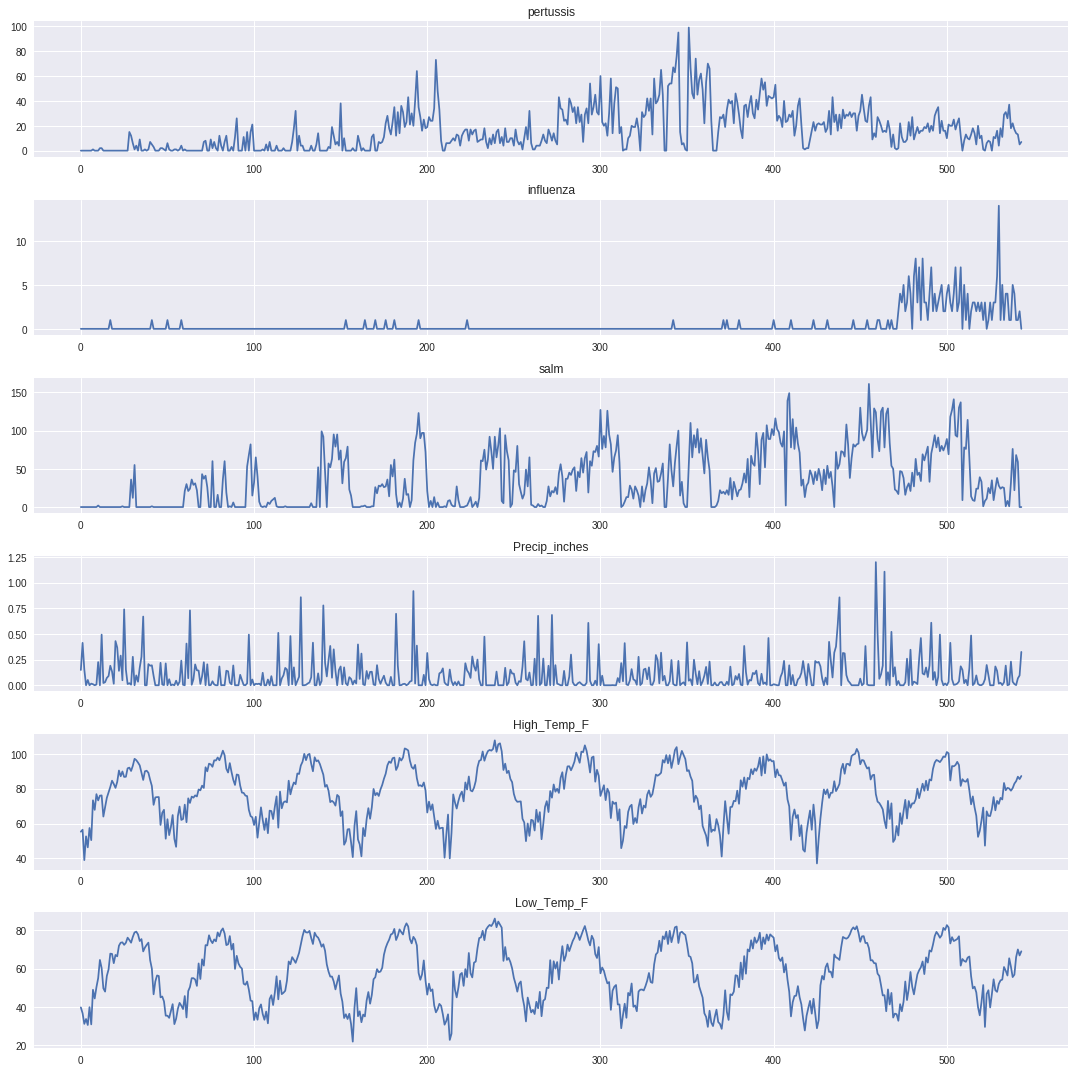

In [0]:
# Visualize response variable (total count) with other vars in hourly dataset
col_list = ['pertussis', 'influenza', 'salm', 'Precip_inches', 'High_Temp_F', 'Low_Temp_F']

fig, ax = plt.subplots(nrows = 6, ncols = 1, figsize=(15,15))
for i in range(len(col_list)):
    ax[i].plot(ts[col_list[i]], label=col_list[i])
    ax[i].set_title(col_list[i])
plt.tight_layout()
plt.show()

<h1>Baseline Model: Start with what you know</h1>

<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add":</font> Start by using the tried and true and/or what the organization has historically always used. Forms a baseline for the organization's acceptance and is a form of stakeholder enagement on the data science side. In this case we will use a linear regression time series forecasting model called the Auto-Regressive Integrated Moving Average (ARIMA) model.</b></font>

For an ARIMA model we need to determine if the data for pertussis is stationary, and then determine the order of the parameters: 

- `p` is the number of autoregressive terms,
- `d` is the number of nonseasonal differences needed for stationarity, and
- `q` is the number of lagged forecast errors in the prediction equation
Ref: https://people.duke.edu/~rnau/411arim.htm


<h2>Statistical understanding of pertussis</h2>
1. Stationarity is an assumption in time series models. This means a constant mean and variance for every time step, `t`

In [0]:
from pandas import Series
from statsmodels.tsa.stattools import adfuller
X = ts['pertussis'].values
result = adfuller(X)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
	print('\t%s: %.3f' % (key, value))

ADF Statistic: -2.477218
p-value: 0.121116
Critical Values:
	5%: -2.867
	1%: -3.443
	10%: -2.570


/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


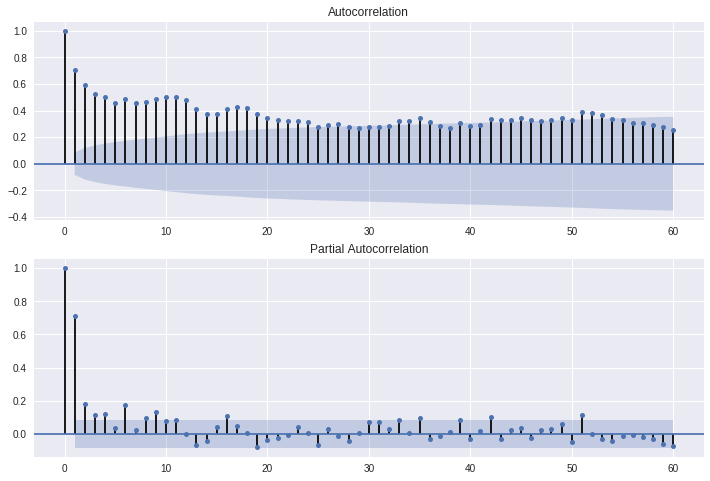

In [0]:
import statsmodels.api as sm

fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(ts['pertussis'], lags=60, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(ts['pertussis'], lags=60, ax=ax2)
plt.show()


<h2>ARIMA using `statsmodels`, (5, 0, 1)</h2>

The general ARIMA forecasting equation is: 

<font size=4>

$$\hat{y}_{t} = \mu + \phi*y_{t-5} + ... + \phi*y_{t-p} - \sigma*e_{t-5} - ... - \sigma*e_{t-q}$$

</font><br>

- sigma: is moving average parameters

In [0]:
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from matplotlib import pyplot

#No Differencing, d = 0
X = ts['pertussis'].values
train, test = X[0:417], X[418:len(X)]
history = [x for x in train]
#fit the model X
predictions = list()
for t in range(len(test)):
    model = ARIMA(history, order=(5,0,1))
    model_fit = model.fit()
    output = model_fit.forecast(steps=1)[0]
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_absolute_error(test, predictions)
print('Test MAE: %.3f' % error)

In [0]:
print(model_fit.summary())
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
pyplot.show()
residuals.plot(kind='kde')
pyplot.show()
print(residuals.describe())

<h2>Grisearch AIC using the `pyramid` package </h2> which is R's auto.arima to Python. 
> Pyramid is a no-nonsense statistical Python library with a solitary objective: bring R's auto.arima functionality to Python. Pyramid operates by wrapping statsmodels.tsa.ARIMA and statsmodels.tsa.statespace.SARIMAX into one estimator class and creating a more user-friendly estimator interface for programmers familiar with scikit-learn.
> https://github.com/tgsmith61591/pyramid


In [0]:
import sys
!{sys.executable} -m pip install pyramid-arima

    100% |████████████████████████████████| 501kB 5.6MB/s 
    100% |████████████████████████████████| 7.4MB 3.2MB/s 
    100% |████████████████████████████████| 3.3MB 7.9MB/s 
  Found existing installation: statsmodels 0.8.0
    Uninstalling statsmodels-0.8.0:
      Successfully uninstalled statsmodels-0.8.0


In [0]:
import pyramid
from pyramid.arima import auto_arima

In [0]:
train = ts['pertussis'].values
stepwise_model = auto_arima(train, 
                            start_p=1, 
                            start_q=1,
                           max_p=5, 
                            max_q=5, 
                            m=12,
                           start_P=0, 
                            seasonal=True,
                           d=0, 
                            D=1, 
                            trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=4168.513, BIC=4189.897, Fit time=0.868 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 1, 0, 12); AIC=4548.083, BIC=4556.637, Fit time=0.040 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 1, 0, 12); AIC=4301.234, BIC=4318.341, Fit time=0.516 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 1, 1, 12); AIC=4262.963, BIC=4280.070, Fit time=0.551 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 1, 12); AIC=4162.828, BIC=4188.487, Fit time=2.447 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 0, 12); AIC=4297.913, BIC=4319.296, Fit time=0.618 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 1, 2, 12); AIC=4162.879, BIC=4192.816, Fit time=8.026 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 1, 0, 12); AIC=4415.317, BIC=4432.424, Fit time=0.256 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(2, 1, 2, 12); AIC=4165.660, BIC=4199.874, Fit time=7.474 seconds
Fit ARIMA: order=(0, 0, 1) s

<h1>Data Preprocessing</h1>

<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add":</font> There are many opportunities to make mistakes in processing the data. From the way you normalize the data, to how you reshape the vector, you can make mistakes. Make sure to transparently document how you are transforming the data to retrace your steps. </b></font>
![fotolia_original_38380192_x2.jpg](attachment:fotolia_original_38380192_x2.jpg)

<h2>Standardization</h2>

<font size=5>
    <center>zero mean and unit variance</center><br>

$$X_{new} =\frac{X-\mu}{\sigma}$$

</font>

In [0]:
def standardized_matrix(df):
    #for stateful LSTM, make pertussis the 1st feature in the column order
    dataframe = df[['pertussis', 'influenza', 'salm', 'Precip_inches','Low_Temp_F', 'High_Temp_F']]
    #first convert to a 2d tensor of shape (timesteps, features)
    matrix = dataframe.values
    #Normalize the whole matrix 
    mean = matrix.mean(axis=0)
    matrix -= mean
    std = matrix.std(axis=0)
    matrix /= std
    print (matrix.shape)
    return matrix 
    
new_matrix = standardized_matrix(ts)

(544, 6)


In [0]:
#All of our 5 independent variables: 'influenza', 'salm', 'Precip_inches','Low_Temp_F', 'High_Temp_F'
new_matrix[:, -5:]

array([[-0.34112302, -0.98503618,  0.2766445 , -1.1901128 , -1.48195298],
       [-0.34112302, -0.98503618,  1.88198975, -1.38706079, -1.40795543],
       [-0.34112302, -0.98503618,  0.30267713, -1.74674515, -2.55351249],
       ...,
       [ 0.37536703,  0.61163678, -0.21797539,  0.76919608,  0.58904183],
       [ 1.09185709, -0.98503618, -0.04442455,  0.56670026,  0.49912075],
       [-0.34112302, -0.98503618,  1.34398215,  0.70632066,  0.61526881]])

In [0]:
#our pertussis target value
new_matrix[:, 0]

array([-0.97957173, -0.97957173, -0.97957173, -0.97957173, -0.97957173,
       -0.97957173, -0.97957173, -0.92062405, -0.97957173, -0.97957173,
       -0.97957173, -0.86167637, -0.86167637, -0.97957173, -0.97957173,
       -0.97957173, -0.97957173, -0.97957173, -0.97957173, -0.97957173,
       -0.97957173, -0.97957173, -0.97957173, -0.97957173, -0.97957173,
       -0.97957173, -0.97957173, -0.97957173, -0.09535654, -0.27219958,
       -0.62588565, -0.92062405, -0.74378101, -0.97957173, -0.44904262,
       -0.97957173, -0.97957173, -0.92062405, -0.97957173, -0.92062405,
       -0.56693798, -0.68483333, -0.80272869, -0.97957173, -0.97957173,
       -0.97957173, -0.86167637, -0.86167637, -0.92062405, -0.97957173,
       -0.62588565, -0.92062405, -0.97957173, -0.97957173, -0.92062405,
       -0.92062405, -0.97957173, -0.92062405, -0.74378101, -0.97957173,
       -0.92062405, -0.97957173, -0.97957173, -0.97957173, -0.97957173,
       -0.97957173, -0.97957173, -0.97957173, -0.97957173, -0.97

<h2>Transform our Data</h2>
<b>Shift pertussis to one time step out</b>

In [0]:
def transform(matrix):
    pertussis = matrix[:, 0]
    pertussis_shifted = pertussis[1:len(pertussis)] #start at the 2nd value (which is index[1])
    
    #take each feature's index value
    flu = matrix[:, 1]
    salm = matrix[:, 2]
    ppt = matrix[:, 3]
    low_temp = matrix[:, 4]
    high_temp = matrix[:, 5]
    
    #convert all to series
    s_flu = pd.Series(flu)
    s_salm = pd.Series(salm)
    s_ppt = pd.Series(ppt)
    s_lt = pd.Series(low_temp)
    s_ht = pd.Series(high_temp)
    s_pert = pd.Series(pertussis_shifted)
    
    #reshape this into a matrix where each "i" is a feature
    ts_new = pd.concat([s_flu, s_salm, s_ppt, s_lt, s_ht, s_pert], axis=1)
    
    #This is only up to the 543rd timestep, becuase we don't have a pertussis target value for 544. 
    #Therefore, I don't have a target for 543. The most complete, last timestep is at 543. 
    ts_new_542 = ts_new.loc[0:542]
    
    #convert it back to a matrix of values , the 6th value is pertussis the target
    tfd_matrix = ts_new_542.values
    print(tfd_matrix.shape)
    print(tfd_matrix[:5])
    return tfd_matrix

sequence_matrix = transform(new_matrix)

(543, 6)
[[-0.34112302 -0.98503618  0.2766445  -1.1901128  -1.48195298 -0.97957173]
 [-0.34112302 -0.98503618  1.88198975 -1.38706079 -1.40795543 -0.97957173]
 [-0.34112302 -0.98503618  0.30267713 -1.74674515 -2.55351249 -0.97957173]
 [-0.34112302 -0.98503618 -0.62581985 -1.58215951 -1.65804843 -0.97957173]
 [-0.34112302 -0.98503618 -0.31342835 -1.78465533 -2.07206005 -0.97957173]]


<h2>Reshape the data, train/test split</h2>
<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add":</font> Dealing with tensors, or collections of arrays is a common practice in neural networks. We recommend using a simple online drawing package like `draw.io` to help draw out what the data shapes look like, as well as referring to your framework's (in this case, Keras's) documentation to understand what is the accepted format for inputs into the model. In this case it is `(batch_size, timesteps, input_dim)`. </b></font>


In [0]:
#a = 181, b=362
def timesequences(sequence_matrix, a, b):

    #timedistributed must take the exact same length for test and train (like padding a sentence)
    train = sequence_matrix[:a] 
    valid = sequence_matrix[a:b]
    test = sequence_matrix[b:]

    #slice the 5 features versus the target
    train_X, train_y = train[:, :5], train[:, 5] #the last column/value is pertussis our target
    valid_X, valid_y = valid[:, :5], valid[:, 5]
    test_X, test_y = test[:, :5], test[:, 5]

    # reshape input to be 3D tensor with shape (batch_size, timesteps, input_dim)
    # needs to be (1, 181, 5)
    train_X = train_X.reshape((1, train_X.shape[0], train_X.shape[1]))
    train_y = train_y.reshape((1, train_y.shape[0], 1))

    valid_X = valid_X.reshape((1, valid_X.shape[0], valid_X.shape[1]))
    valid_y = valid_y.reshape((1, valid_y.shape[0], 1))

    test_X = test_X.reshape((1, test_X.shape[0], test_X.shape[1]))
    test_y = test_y.reshape((1, test_y.shape[0], 1))

    print(train_X.shape, train_y.shape, valid_X.shape, valid_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, valid_X, valid_y, test_X, test_y

In [0]:
train_X, train_y, valid_X, valid_y, test_X, test_y = timesequences(sequence_matrix, 181,362)

((1, 181, 5), (1, 181, 1), (1, 181, 5), (1, 181, 1), (1, 181, 5), (1, 181, 1))


In [0]:
train_X[0][0] #the oldest values b/c these were the first in the dataframe in June 2007

array([-0.34112302, -0.98503618,  0.2766445 , -1.1901128 , -1.48195298])

In [0]:
train_X[0][180] #the most recent values

array([-0.34112302,  0.09745396, -0.62581985,  1.30641102,  1.2849935 ])

<b><font size = 4 face='Times'>So for our data, we have 3 sets each with 181-length sequences or the first 3.5 years, the next 3.5 years, and the last 3.5 years. </b></font>

<h1>Build the model</h1>
<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add":</font> Neural network models are hard to understand. By drawing out conceptually the model architecture, we can better understand what activities are occuring. Consider similarly when drawing the architecture for a convolutional neural network where we depict activities such as dropout, pooling, etc. </b></font>

<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add":</font> Jupyter Notebooks offer a great opportunity to educate our clients. Use a notebook as you would a tutorial and deliver value by explaining what type of model you have selected. Here, each LSTM unit's cell state is dependent on the previous cell state and hidden state and input sequence.</b></font>

<b><font size = 4 face='Times'>Define our loss metrics. It's the same one we used for the ARIMA model, as well. </b></font>

<font size=5>
    <center>Loss Metric: Mean Absolute Error </center>

$$MAE =\frac{1}{T}\sum\left|{{y}_{2} - \hat{y}_{2}}\right|$$

</font>

In [0]:
from keras.layers import TimeDistributed, Dropout

length=train_X.shape[1] #181

model = Sequential()
model.add(LSTM(128, input_shape=(length, 5), return_sequences=True))
model.add(LSTM(128,input_shape=(length, 5), return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mean_absolute_error', optimizer='adam')

# train LSTM
#there is only 1 batch so we can't train/test split this
history = model.fit(train_X, 
                    train_y, 
                    epochs=200, 
                    batch_size=6, 
                    verbose=2)

print(model.summary())

Epoch 1/200
 - 2s - loss: 0.7932
Epoch 2/200
 - 0s - loss: 0.6540
Epoch 3/200
 - 0s - loss: 0.5101
Epoch 4/200
 - 0s - loss: 0.3741
Epoch 5/200
 - 0s - loss: 0.4151
Epoch 6/200
 - 0s - loss: 0.3891
Epoch 7/200
 - 0s - loss: 0.3136
Epoch 8/200
 - 0s - loss: 0.3106
Epoch 9/200
 - 0s - loss: 0.3310
Epoch 10/200
 - 0s - loss: 0.3394
Epoch 11/200
 - 0s - loss: 0.3296
Epoch 12/200
 - 0s - loss: 0.3096
Epoch 13/200
 - 0s - loss: 0.2884
Epoch 14/200
 - 0s - loss: 0.2734
Epoch 15/200
 - 0s - loss: 0.2753
Epoch 16/200
 - 0s - loss: 0.2838
Epoch 17/200
 - 0s - loss: 0.2842
Epoch 18/200
 - 0s - loss: 0.2726
Epoch 19/200
 - 0s - loss: 0.2598
Epoch 20/200
 - 0s - loss: 0.2556
Epoch 21/200
 - 0s - loss: 0.2569
Epoch 22/200
 - 0s - loss: 0.2606
Epoch 23/200
 - 0s - loss: 0.2604
Epoch 24/200
 - 0s - loss: 0.2555
Epoch 25/200
 - 0s - loss: 0.2491
Epoch 26/200
 - 0s - loss: 0.2465
Epoch 27/200
 - 0s - loss: 0.2449
Epoch 28/200
 - 0s - loss: 0.2451
Epoch 29/200
 - 0s - loss: 0.2468
Epoch 30/200
 - 0s - lo

<h3>Loss Plots</h3>

`tensorboard --logdir==training:/Users/559048/Documents/disease_lstm/logs_jupytercon/demo_lstm`

<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add":</font> Loss plots when visualizing the training versus validation loss are important. Our simple example only shows the training loss because we have one sample `(1, 181, 5)`. However, when we run other models using different data processing techniques (see Data Processing Approach 2), we can then visualize our training versus validation loss either in a Jupyter Notebook via `matplotlib` or `seaborn` or also by using callbacks in `tensorflow` via Tensorboard below. </b></font>

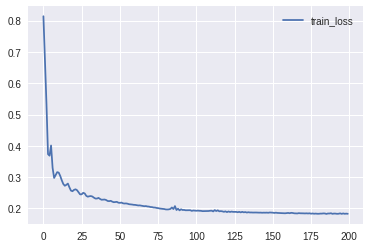

In [0]:
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.legend()
plt.show()

<h3>MAE Score and Predictions</h3>

<b><font size = 4 face='Times'>Here are our scores for how the model performed on the validation set and the test set.</b>

In [0]:
lstm_valid_time_score = model.evaluate(valid_X, valid_y)
print(lstm_valid_time_score)

1/1 [==============================] - 0s 189ms/step
1.0028859376907349


In [0]:
#Reshape the validation and test Y series for Pertussis
y_val = pd.Series(valid_y.reshape(181,))
print(y_val.shape)
y_test = pd.Series(test_y.reshape(181,))
print(y_test.shape)

(181,)
(181,)


In [0]:
def predictions(data, batch_size, seq_len):
    result = model.predict(data, batch_size, verbose=1)
    predictions = pd.Series(result.reshape(seq_len),)
    print(predictions.shape)
    return predictions

In [0]:
valid_preds= predictions(valid_X, 1, 181)

1/1 [==============================] - 0s 202ms/step
(181,)


In [0]:
test_preds = predictions(test_X, 1, 181)

1/1 [==============================] - 0s 32ms/step
(181,)


In [0]:
def predictions_dataframe(predictions, series_y):
    df = pd.concat([predictions, series_y], axis=1)
    df.rename(columns={0: 'pred', 1: 'actual'}, inplace=True)
    print(df.plot(figsize=(12,5)))
    return df

AxesSubplot(0.125,0.125;0.775x0.755)


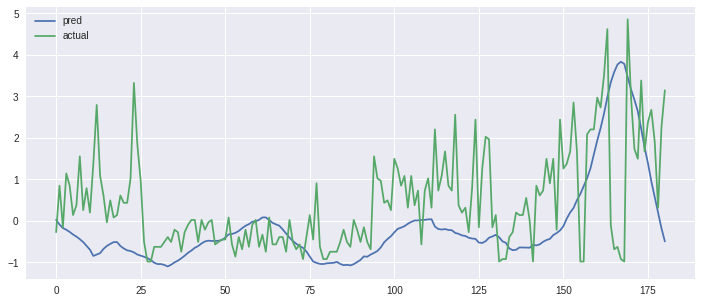

In [0]:
valid_df = predictions_dataframe(valid_preds, y_val)

In [0]:
lstm_test_time_score = model.evaluate(test_X, test_y)
print(lstm_test_time_score)

1/1 [==============================] - 0s 34ms/step
2.482095241546631


AxesSubplot(0.125,0.125;0.775x0.755)


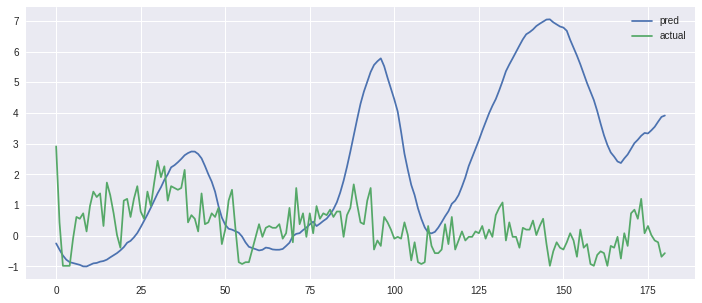

In [0]:
test_df = predictions_dataframe(test_preds, y_test)

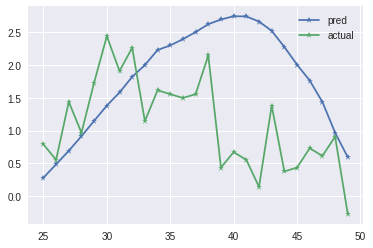

In [0]:
test_df[25:50].plot(marker="*")

<h1>Get the Model Configurations</h1>

<b><font size = 4 face='Times'><font color=#ff0000>The transparency "value-add": </font> Start inventorying the hyperparameters you have tuned to build your models. You'll find that you'll build dozens of models and sometimes lose track of what you've tuned. While a spreadsheet can work, it would be nice to be able to summarize all your model configurations in a notebook. Right here we output the configurations, but at the end of the presentation we'll see a summary of all seven models in the main notebook. </b></font>


In [0]:
def params(model):
    holder = []
    model_state = model.get_config()
    for i in range (0, len(model_state)):
        holder.append(model_state[i])
    return holder

In [0]:
lstm_time = params(model)
lstm_time

[{'class_name': 'LSTM',
  'config': {'activation': 'tanh',
   'activity_regularizer': None,
   'batch_input_shape': (None, 181, 5),
   'bias_constraint': None,
   'bias_initializer': {'class_name': 'Zeros', 'config': {}},
   'bias_regularizer': None,
   'dropout': 0.0,
   'dtype': 'float32',
   'go_backwards': False,
   'implementation': 1,
   'kernel_constraint': None,
   'kernel_initializer': {'class_name': 'VarianceScaling',
    'config': {'distribution': 'uniform',
     'mode': 'fan_avg',
     'scale': 1.0,
     'seed': None}},
   'kernel_regularizer': None,
   'name': 'lstm_1',
   'recurrent_activation': 'hard_sigmoid',
   'recurrent_constraint': None,
   'recurrent_dropout': 0.0,
   'recurrent_initializer': {'class_name': 'Orthogonal',
    'config': {'gain': 1.0, 'seed': None}},
   'recurrent_regularizer': None,
   'return_sequences': True,
   'return_state': False,
   'stateful': False,
   'trainable': True,
   'unit_forget_bias': True,
   'units': 128,
   'unroll': False,
   'u

In [0]:
#layers
layer_dict= dict([(layer.name, layer) for layer in model.layers])
num_lstm_time_layers = len(layer_dict)
print(num_lstm_time_layers)

3


<h1>Compute the Gradients</h1>

<b><font face="Times" size=4><font color=#ff0000>The Transparency "Value Add".</font> By computing the gradients wrt to the inputs, we can begin to understand which of the features are more sensitive to the model's prediction error. This gives us an intuition about which of the five independent features the predictions are most sensitive to. Where a derivative is the rate of change of one output w.r.t to an input for a single input; a "gradient" is a collection, or vector, of derivatives for multiple inputs, calculated through partial differentiation.
</b></font>

<font size=4>

output vector: $$ y \in {\rm I\!R}^m$$ where $$ y = f(x) $$ and input vector: $$ x \in {\rm I\!R}^n$$

We compute: 

$$J_{ij}(x) = \frac{\partial}{\partial x_j}f_i(x)$$

>Gradient (also called Jacobian) gives the local rate of change of each output w.r.t. each input, so it tells us how f will behave in response to infinitesimal perturbations. 

</font>
Refs: 
- https://stats.stackexchange.com/questions/263657/sensitivity-analysis-in-deep-neural-networks
- ftp://ftp.sas.com/pub/neural/importance.html
- Yeung, et al "Principles of Sensitivity Analysis" in Natural Computing Series, Sensitivity Analysis for Neural Networks


<h3>The gradients of the outputs w.r.t. the inputs of train_x</h3>

Similar to learning what words are most sensitive to predictions in a paragraph or a saliency map for pixel features in an image.

Ref: https://www.civisanalytics.com/blog/interpreting-visualizing-neural-networks-text-processing/<br>
Ref: Leila Arras, Franziska Horn, Grégoire Montavon, Klaus-Robert Müller, and Wojciech Samek (2016). Explaining Predictions of Non-Linear Classifiers in NLP<br>
Ref: Karen Simonyan, Andrea Vedaldi, and Andrew Zisserman (2014). Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps


In [0]:
import tensorflow as tf
from keras import backend as K

In [0]:
import sys
!{sys.executable} -m pip install keras --upgrade

    100% |████████████████████████████████| 307kB 4.1MB/s 
    100% |████████████████████████████████| 51kB 8.2MB/s 
  Found existing installation: Keras 2.1.6
    Uninstalling Keras-2.1.6:
      Successfully uninstalled Keras-2.1.6


In [0]:
import sys
!{sys.executable} -m pip install tensorflow --upgrade

Requirement already up-to-date: tensorflow in /usr/local/lib/python2.7/dist-packages (1.10.0)


In [0]:
def gradients(output_y, input_x, model):
    v_expected = np.asarray(output_y.shape)
    v_tf_expected = K.variable(v_expected)
    #loss = K.sum(K.square(v_tf_expected - model.output))
    loss = K.sum(K.abs(v_tf_expected - model.output))
    grad = K.gradients(loss, [model.input, v_tf_expected])[0]
    fn = K.function([model.input, v_tf_expected], [grad])
    grads = fn([input_x, output_y])[0]
    print(grads.shape)
    return grads

train_grads = gradients(train_y, train_X, model)

In [0]:
train_grads

array([[[ 9.51574892e-02,  9.64631215e-02, -1.01950347e-01,
          1.12607792e-01,  1.14275813e-01],
        [ 4.07045111e-02,  5.57450168e-02, -3.50624323e-02,
          7.27635249e-02,  7.25037605e-02],
        [ 3.91045772e-03,  2.32765768e-02,  7.83966202e-03,
          2.88246181e-02,  2.88081560e-02],
        [-2.01555863e-02, -1.60786463e-03,  3.53644341e-02,
         -1.45902121e-02, -1.37557518e-02],
        [-2.45700665e-02, -1.60735529e-02,  2.25856528e-02,
         -4.93051820e-02, -4.86924872e-02],
        [ 1.03339246e-02, -1.87494315e-03, -1.99262109e-02,
         -2.01624315e-02, -2.04905253e-02],
        [ 3.27498913e-02,  1.80621017e-02, -5.03088385e-02,
          1.54919885e-02,  1.36260120e-02],
        [ 3.67518738e-02,  3.24007608e-02, -4.23876792e-02,
          4.70527783e-02,  4.42930572e-02],
        [ 2.90298578e-03,  1.99788827e-02, -9.04138386e-03,
          2.58868542e-02,  2.31244136e-02],
        [-2.18863301e-02,  2.61198403e-03,  1.83902755e-02,
    

In [0]:
#plot mean of each feature

def mean_feature_gradients(grads):
    foo = (np.abs(grads).mean(axis=1)).reshape(np.abs(grads).shape[2],)
    foo1 = pd.Series((foo.transpose()))
    var_list = ['influenza', 'salm', 'Precip_inches','Low_Temp_F', 'High_Temp_F']
    var_list1 =pd.Series(var_list)
    print(((pd.DataFrame([var_list1, foo1]).transpose()).set_index(0)).plot(kind='bar'))

AxesSubplot(0.125,0.125;0.775x0.755)


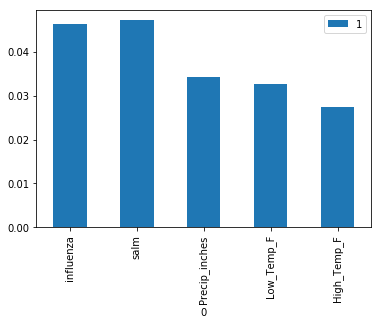

In [0]:
mean_feature_gradients(train_grads)

In [0]:
for i in range(train_grads.shape[1]):
        print (i, np.abs(train_grads[:,i,:]).sum())

(0, 0.5204546)
(1, 0.27677923)
(2, 0.092659466)
(3, 0.08547385)
(4, 0.16122693)
(5, 0.07278804)
(6, 0.13023883)
(7, 0.20288615)
(8, 0.08093452)
(9, 0.046726935)
(10, 0.11144251)
(11, 0.028485524)
(12, 0.05649253)
(13, 0.057423398)
(14, 0.12208428)
(15, 0.049306266)
(16, 0.060181715)
(17, 0.1273564)
(18, 0.05935306)
(19, 0.028388744)
(20, 0.07069808)
(21, 0.06059739)
(22, 0.059294265)
(23, 0.08073804)
(24, 0.059905447)
(25, 0.050570127)
(26, 0.03958258)
(27, 0.056570075)
(28, 0.044421233)
(29, 0.076798916)
(30, 0.0954338)
(31, 0.078816116)
(32, 0.08858859)
(33, 0.059633937)
(34, 0.06292991)
(35, 0.044022754)
(36, 0.021713981)
(37, 0.048342932)
(38, 0.03106551)
(39, 0.036079403)
(40, 0.07069057)
(41, 0.101183124)
(42, 0.12377337)
(43, 0.07048271)
(44, 0.025894187)
(45, 0.063672185)
(46, 0.05000264)
(47, 0.075463556)
(48, 0.038275767)
(49, 0.09297071)
(50, 0.06824526)
(51, 0.13778378)
(52, 0.0797762)
(53, 0.03280805)
(54, 0.0642903)
(55, 0.022476014)
(56, 0.079442464)
(57, 0.04724362)
(58

In [0]:
def list_of_gradients(grads):
    holder = []
    for i in range(grads.shape[1]):
        holder.append(tuple((i, np.abs(grads[:,i,:]).sum())))
    df = pd.DataFrame(holder)
    print (df[1].plot(figsize=(10,5)))
    return holder

AxesSubplot(0.125,0.125;0.775x0.755)


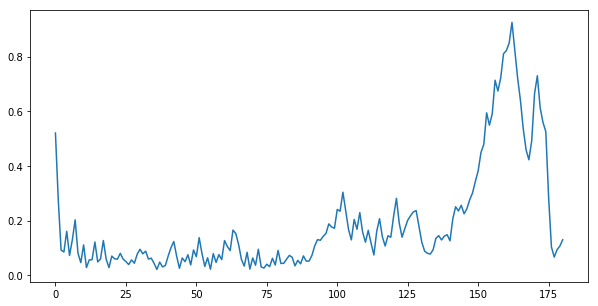

In [0]:
my_train_grads = list_of_gradients(train_grads)

In [0]:
print(train_X.shape)
print(train_grads[0].shape)

(1, 181, 5)
(181, 5)


<b>Slice the list to get:</b>
    - Influenza: the 1st feature, so -5 
    - Salmonella: the 2nd feature, so -4
    - Precipitation: the 3rd feature, so -3
    - Low Temperature: the 4th feature, so -2
    - High Temperature: the 5th feature, so -1

In [0]:
def gradients_viz(grads):
    flu_grads_wrt_train = pd.Series(grads[0][:, -5])
    salm_grads_wrt_train = pd.Series(grads[0][:, -4])
    ppt_grads_wrt_train = pd.Series(grads[0][:, -3])
    lt_grads_wrt_train = pd.Series(grads[0][:, -2])
    ht_grads_wrt_train = pd.Series(grads[0][:, -1])
    #names
    flu_name = ['influenza'] * len(pd.Series(grads[0][:, -5]))
    salm_name = ['salmonella'] * len(pd.Series(grads[0][:, -4]))
    ppt_name = ['ppt'] * len(pd.Series(grads[0][:, -3]))
    lt_name = ['low_temp'] * len(pd.Series(grads[0][:, -2]))
    ht_name = ['high_temp'] * len(pd.Series(grads[0][:, -1]))
    #dataframe
    df = pd.concat([flu_grads_wrt_train, 
                    pd.Series(flu_name), 
                    salm_grads_wrt_train, 
                    pd.Series(salm_name),
                    ppt_grads_wrt_train,
                    pd.Series(ppt_name), 
                    lt_grads_wrt_train,
                    pd.Series(lt_name), 
                    ht_grads_wrt_train,
                    pd.Series(ht_name)], axis=1)
    #overall df
    train_signals = df.reset_index()
    train_signals.rename(index=str, columns={0: "influ", 
                                             2: "salm",
                                            4: "ppt",
                                            6:"low_temp",
                                            8:"high_temp"}, inplace=True)
    print(np.abs(train_signals[['influ', 'salm', 'ppt', 'low_temp', 'high_temp']]).plot(kind='line', figsize=(12,4)))
    return train_signals

The predictions are more sensitive to influenza in the first 6 years. 

AxesSubplot(0.125,0.125;0.775x0.755)


,index,influ,1,salm,3,ppt,5,low_temp,7,high_temp,9
0,0,0.095157,influenza,0.096463,salmonella,-0.101950,ppt,0.112608,low_temp,0.114276,high_temp
1,1,0.040705,influenza,0.055745,salmonella,-0.035062,ppt,0.072764,low_temp,0.072504,high_temp
2,2,0.003910,influenza,0.023277,salmonella,0.007840,ppt,0.028825,low_temp,0.028808,high_temp
3,3,-0.020156,influenza,-0.001608,salmonella,0.035364,ppt,-0.014590,low_temp,-0.013756,high_temp
4,4,-0.024570,influenza,-0.016074,salmonella,0.022586,ppt,-0.049305,low_temp,-0.048692,high_temp
5,5,0.010334,influenza,-0.001875,salmonella,-0.019926,ppt,-0.020162,low_temp,-0.020491,high_temp
6,6,0.032750,influenza,0.018062,salmonella,-0.050309,ppt,0.015492,low_temp,0.013626,high_temp
7,7,0.036752,influenza,0.032401,salmonella,-0.042388,ppt,0.047053,low_temp,0.044293,high_temp
8,8,0.002903,influenza,0.019979,salmonella,-0.009041,ppt,0.025887,low_temp,0.023124,high_temp
9,9,-0.021886,influenza,0.002612,salmonella,0.018390,ppt,-0.000044,low_temp,-0.003794,high_temp


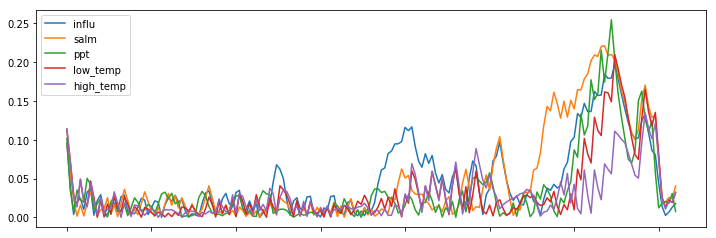

In [0]:
gradients_viz(train_grads)

<h3>The gradients w.r.t. the inputs of valid_x</h3>

In [0]:
valid_grads = gradients(valid_y, valid_X, model)

(1, 181, 5)


AxesSubplot(0.125,0.125;0.775x0.755)


,index,influ,1,salm,3,ppt,5,low_temp,7,high_temp,9
0,0,-0.650870,influenza,-0.833654,salmonella,0.168885,ppt,-0.139192,low_temp,0.308598,high_temp
1,1,-0.627148,influenza,-0.809574,salmonella,0.204849,ppt,-0.207767,low_temp,0.220336,high_temp
2,2,-0.736044,influenza,-0.761597,salmonella,0.159664,ppt,-0.194388,low_temp,0.208846,high_temp
3,3,-0.794133,influenza,-0.718234,salmonella,0.164880,ppt,-0.221219,low_temp,0.163695,high_temp
4,4,-0.798530,influenza,-0.589204,salmonella,0.137330,ppt,-0.218914,low_temp,0.154744,high_temp
5,5,-0.812044,influenza,-0.450991,salmonella,0.108867,ppt,-0.224429,low_temp,0.137312,high_temp
6,6,-0.830058,influenza,-0.301425,salmonella,0.076123,ppt,-0.235961,low_temp,0.113189,high_temp
7,7,-0.847811,influenza,-0.142883,salmonella,0.044261,ppt,-0.254748,low_temp,0.078570,high_temp
8,8,-0.882067,influenza,0.037129,salmonella,0.012154,ppt,-0.286612,low_temp,0.036606,high_temp
9,9,-0.923225,influenza,0.244644,salmonella,-0.015694,ppt,-0.333511,low_temp,-0.015396,high_temp


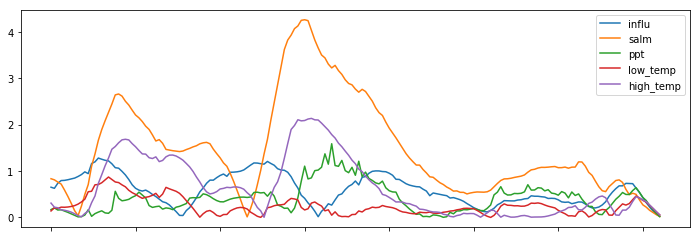

In [0]:
gradients_viz(valid_grads)

<h3>The gradients w.r.t. the inputs of test_x</h3>

In [0]:
test_grads = gradients(test_y, test_X, model)

(1, 181, 5)


AxesSubplot(0.125,0.125;0.775x0.755)


,index,influ,1,salm,3,ppt,5,low_temp,7,high_temp,9
0,0,0.062787,influenza,-2.039392,salmonella,0.162491,ppt,-0.185522,low_temp,1.042813,high_temp
1,1,0.053669,influenza,-1.966304,salmonella,0.306064,ppt,-0.116630,low_temp,1.122422,high_temp
2,2,-0.077028,influenza,-1.841025,salmonella,0.318119,ppt,-0.072520,low_temp,1.113558,high_temp
3,3,-0.208618,influenza,-1.765615,salmonella,0.416419,ppt,-0.142639,low_temp,1.010182,high_temp
4,4,-0.317321,influenza,-1.701128,salmonella,0.487636,ppt,-0.211889,low_temp,0.893862,high_temp
5,5,-0.399893,influenza,-1.620286,salmonella,0.495203,ppt,-0.275592,low_temp,0.778683,high_temp
6,6,-0.448138,influenza,-1.522245,salmonella,0.487621,ppt,-0.287746,low_temp,0.732606,high_temp
7,7,-0.495577,influenza,-1.435819,salmonella,0.484668,ppt,-0.293842,low_temp,0.679427,high_temp
8,8,-0.551207,influenza,-1.332747,salmonella,0.482209,ppt,-0.282372,low_temp,0.607296,high_temp
9,9,-0.596539,influenza,-1.239027,salmonella,0.472237,ppt,-0.282482,low_temp,0.536665,high_temp


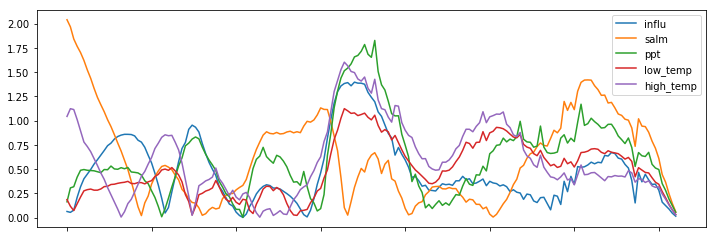

In [0]:
gradients_viz(test_grads)

# Data Processing Approach 2

<b><font face=Times size=4>What if we made the sequences shorter, into overlapping 3-timestep sequences.</font></b>

In [0]:
# convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

def get_sequence(data, n_past, nth_var=1, n_forecast=1, dropnan=True):
    seq = series_to_supervised(data, n_past, n_forecast, dropnan)
    # drop columns we don't want to predict
    col_index = range(seq.shape[1]-data.shape[1],seq.shape[1])
    del col_index[nth_var-1]
    seq.drop(seq.columns[col_index], axis=1, inplace=True)
    return seq

![Screen%20Shot%202018-08-21%20at%2010.23.40%20AM.png](attachment:Screen%20Shot%202018-08-21%20at%2010.23.40%20AM.png)

In [0]:
def overlapping_sequences(new_matrix, nth_feat_predict, n_weeks_back, n_train_weeks):
    values = new_matrix
    # normalize features using scaling
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled = scaler.fit_transform(values)
    
    # generate the sequence
    seq = get_sequence(scaled, n_weeks_back, nth_feat_predict)
    # split into train and test sets
    values = seq.values

    # Randomize the dataset
    indexes = np.random.permutation(values.shape[0])

    train_idx = indexes[0:n_train_weeks] #random index values
    test_idx = indexes[n_train_weeks:values.shape[0]]

    train_X = values[train_idx,0:-1] #the values at these indices
    train_y = values[train_idx,-1]

    test_X = values[test_idx,0:-1]
    test_y = values[test_idx,-1]

    # reshape input to be 3D tensor with shape (batch_size, timesteps, input_dim)
    train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
    test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
    
    print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)
    return train_X, train_y, test_X, test_y


In [0]:
train_X, train_y, test_X, test_y = overlapping_sequences(new_matrix,1,3,400)

((400, 1, 18), (400,), (141, 1, 18), (141,))


<h2>Build the model</h2>

In [0]:
from keras.callbacks import TensorBoard
from keras import optimizers
from keras.layers import Dropout
from keras import regularizers

tb_callback = TensorBoard(log_dir="/Users/559048/Documents/disease_lstm/logs_jupytercon/demo_lstm", 
                          histogram_freq=1, 
                          write_graph=True, 
                          write_images=True)

#might want to experiment with the batch size

model = Sequential()
model.add(LSTM(10, 
               kernel_regularizer=regularizers.l2(0.01), 
               input_shape=(train_X.shape[1], 
                            train_X.shape[2]), 
               return_sequences=False))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(train_X, 
                    train_y, 
                    epochs=200, 
                    batch_size=6,
                    validation_split = 0.2, 
                    verbose=1, 
                    shuffle=False, callbacks=[tb_callback])

Train on 320 samples, validate on 80 samples
Epoch 1/200
320/320 [==============================] - 1s 2ms/step - loss: 0.3357 - val_loss: 0.2742
Epoch 2/200
320/320 [==============================] - 0s 424us/step - loss: 0.2514 - val_loss: 0.2116
Epoch 3/200
320/320 [==============================] - 0s 425us/step - loss: 0.1966 - val_loss: 0.1693
Epoch 4/200
320/320 [==============================] - 0s 425us/step - loss: 0.1620 - val_loss: 0.1429
Epoch 5/200
320/320 [==============================] - 0s 428us/step - loss: 0.1399 - val_loss: 0.1263
Epoch 6/200
320/320 [==============================] - 0s 425us/step - loss: 0.1253 - val_loss: 0.1155
Epoch 7/200
320/320 [==============================] - 0s 428us/step - loss: 0.1162 - val_loss: 0.1093
Epoch 8/200
320/320 [==============================] - 0s 469us/step - loss: 0.1098 - val_loss: 0.1054
Epoch 9/200
320/320 [==============================] - 0s 498us/step - loss: 0.1055 - val_loss: 0.1021
Epoch 10/200
320/320 [========

320/320 [==============================] - 0s 406us/step - loss: 0.0808 - val_loss: 0.0857
Epoch 80/200
320/320 [==============================] - 0s 443us/step - loss: 0.0801 - val_loss: 0.0860
Epoch 81/200
320/320 [==============================] - 0s 459us/step - loss: 0.0802 - val_loss: 0.0859
Epoch 82/200
320/320 [==============================] - 0s 492us/step - loss: 0.0807 - val_loss: 0.0856
Epoch 83/200
320/320 [==============================] - 0s 507us/step - loss: 0.0804 - val_loss: 0.0856
Epoch 84/200
320/320 [==============================] - 0s 491us/step - loss: 0.0804 - val_loss: 0.0860
Epoch 85/200
320/320 [==============================] - 0s 484us/step - loss: 0.0809 - val_loss: 0.0855
Epoch 86/200
320/320 [==============================] - 0s 486us/step - loss: 0.0804 - val_loss: 0.0853
Epoch 87/200
320/320 [==============================] - 0s 483us/step - loss: 0.0797 - val_loss: 0.0855
Epoch 88/200
320/320 [==============================] - 0s 509us/step - loss:

320/320 [==============================] - 0s 486us/step - loss: 0.0794 - val_loss: 0.0841
Epoch 158/200
320/320 [==============================] - 0s 435us/step - loss: 0.0784 - val_loss: 0.0845
Epoch 159/200
320/320 [==============================] - 0s 477us/step - loss: 0.0789 - val_loss: 0.0843
Epoch 160/200
320/320 [==============================] - 0s 480us/step - loss: 0.0789 - val_loss: 0.0843
Epoch 161/200
320/320 [==============================] - 0s 509us/step - loss: 0.0783 - val_loss: 0.0844
Epoch 162/200
320/320 [==============================] - 0s 447us/step - loss: 0.0782 - val_loss: 0.0849
Epoch 163/200
320/320 [==============================] - 0s 400us/step - loss: 0.0789 - val_loss: 0.0843
Epoch 164/200
320/320 [==============================] - 0s 514us/step - loss: 0.0784 - val_loss: 0.0841
Epoch 165/200
320/320 [==============================] - 0s 487us/step - loss: 0.0781 - val_loss: 0.0841
Epoch 166/200
320/320 [==============================] - 0s 497us/ste

<h3>Loss Plots</h3>

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 10)                1160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 11        
Total params: 1,171
Trainable params: 1,171
Non-trainable params: 0
_________________________________________________________________


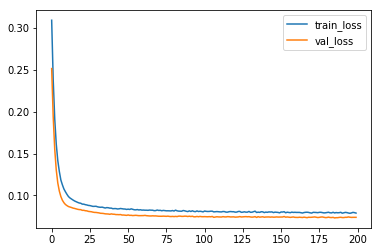

In [0]:
#Save the model
model.save('lstm_08182018.h5') 
model.summary()
# plot history
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

<h3> MAE Score and Predictions</h3>

In [0]:
lstm_2_score = model.evaluate(test_X, test_y, batch_size=1)
print(lstm_2_score)

141/141 [==============================] - 0s 757us/step
0.08977423738424026


141/141 [==============================] - 0s 2ms/step


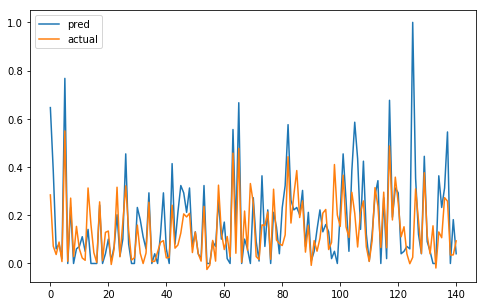

In [0]:
yhat = model.predict(test_X, verbose=1)
pertussis_predictions = pd.DataFrame(yhat, test_y)
pertussis_predictions.reset_index(inplace=True)
pertussis_predictions.rename(columns={'index': 'pred', 0: 'actual'}, inplace=True)
pertussis_predictions.plot(figsize=(8,5))

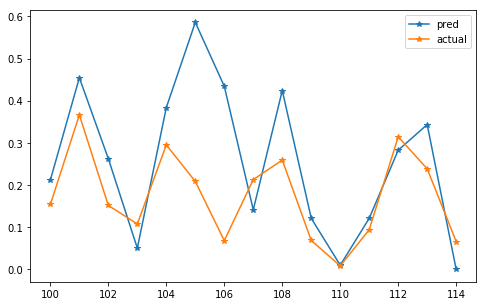

In [0]:
pertussis_predictions[100:115].plot(figsize=(8,5), marker="*")

In [0]:
train_X.shape[0]

400

<h3>Get the Model Configurations</h3>

In [0]:
lstm_2 = params(model)
layer_dict= dict([(layer.name, layer) for layer in model.layers])
num_lstm2_layers = len(layer_dict)
print(num_lstm2_layers)

2


<h3>Fetch the Model Weights</h3>

Remember these formulas: 

$$f_{t} =\sigma({W_{f}} [h_{t-1}, x_t] + b_{f})$$

$$i_{t} =\sigma(W_{i} [h_{t-1}, x_t] + b_{i})$$

$$C_{current} =tanh(W_{c} [h_{t-1}, x_t] + b_{c})$$

$$o_{t} =f_{t}*C_{t-1} + i_{t}*C_{current}$$

$$C_{t} =\sigma(W_{o} [h_{t-1}, x_t] + b_{o})$$

$$h_{t} =o_{t}*tanhC_{t}$$



In [0]:
for weight in model.get_weights(): # weights from Dense layer omitted
    print(weight.shape)

(18, 40)
(10, 40)
(40,)
(10, 1)
(1,)


In [0]:
#https://github.com/keras-team/keras/issues/3088W = model.layers[0].get_weights()[0]
W = model.layers[0].get_weights()[0]
U = model.layers[0].get_weights()[1]
b = model.layers[0].get_weights()[2]
units = 10
W_i = W[:, :units]
W_f = W[:, units: units * 2]
W_c = W[:, units * 2: units * 3]
W_o = W[:, units * 3:]

U_i = U[:, :units]
U_f = U[:, units: units * 2]
U_c = U[:, units * 2: units * 3]
U_o = U[:, units * 3:]

b_i = b[:units]
b_f = b[units: units * 2]
b_c = b[units * 2: units * 3]
b_o = b[units * 3:]

<h4>Linear Transformation of Inputs: W, Weights</h4>

In [0]:
import seaborn as sns
def W_neuron(unit):
    i = unit - 1
    #put it all together in one fiture NEURON 1
    fig, axs = plt.subplots(nrows=4, figsize=(10, 5))
    sns.heatmap(data = ((W_i[:, i]).reshape(18, 1)).transpose(), ax=axs[0])
    sns.heatmap(data = ((W_f[:, i]).reshape(18, 1)).transpose(), ax=axs[1])
    sns.heatmap(data = ((W_c[:, i]).reshape(18, 1)).transpose(), ax=axs[2])
    sns.heatmap(data = ((W_o[:, i]).reshape(18, 1)).transpose(), ax=axs[3])

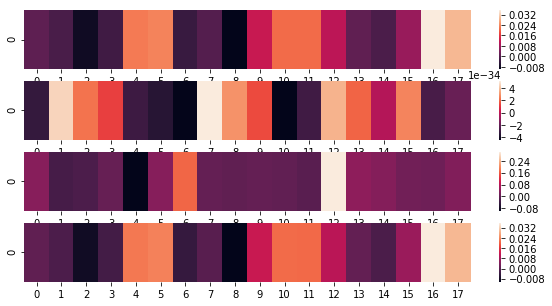

In [0]:
W_neuron(1)

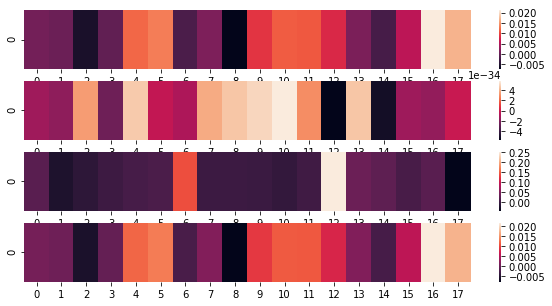

In [0]:
W_neuron(2)

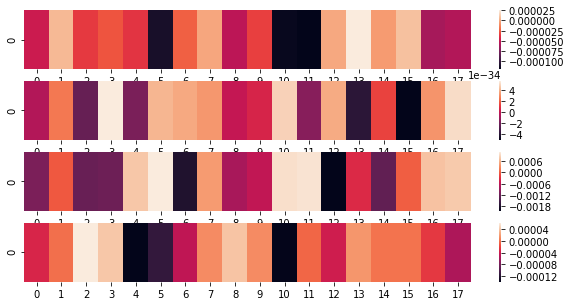

In [0]:
W_neuron(3)

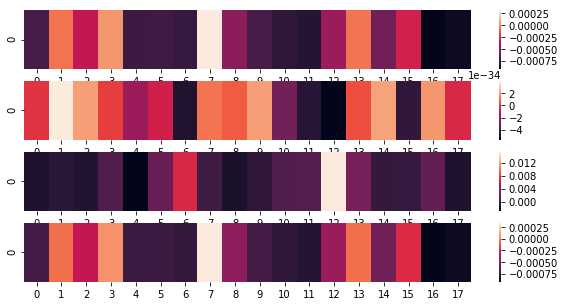

In [0]:
W_neuron(4)

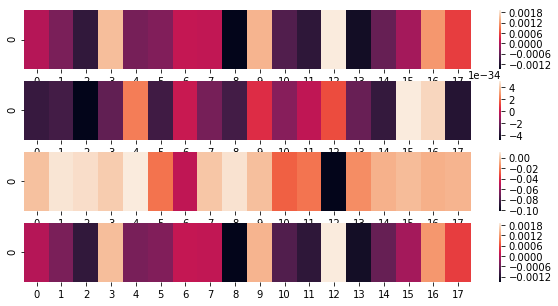

In [0]:
W_neuron(5)

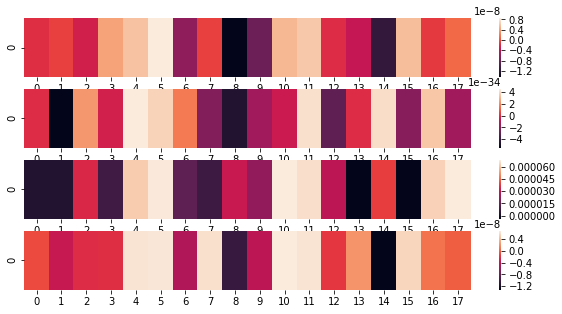

In [0]:
W_neuron(6)

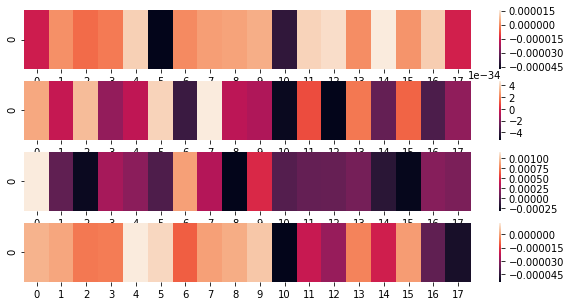

In [0]:
W_neuron(7)

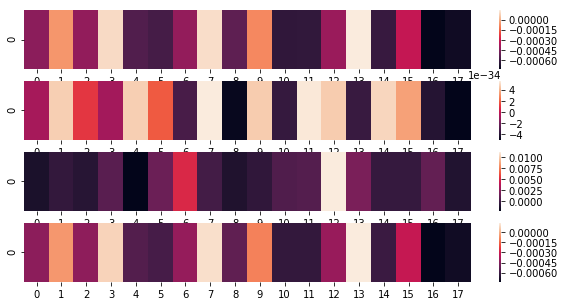

In [0]:
W_neuron(8)

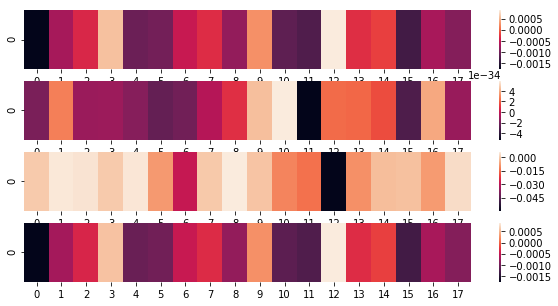

In [0]:
W_neuron(9)

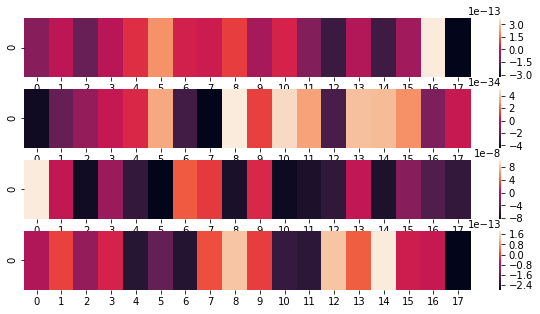

In [0]:
W_neuron(10)

<h4>Linear Transformation of Kernel: U, Weights</h4>

In [0]:
def U_neuron(unit):
    i = unit - 1
    #put it all together in one fiture NEURON 1
    fig, axs = plt.subplots(nrows=4, figsize=(10, 3))
    sns.heatmap(data = ((U_i[:, i]).reshape(10, 1)).transpose(), ax=axs[0])
    sns.heatmap(data = ((U_f[:, i]).reshape(10, 1)).transpose(), ax=axs[1])
    sns.heatmap(data = ((U_c[:, i]).reshape(10, 1)).transpose(), ax=axs[2])
    sns.heatmap(data = ((U_o[:, i]).reshape(10, 1)).transpose(), ax=axs[3])

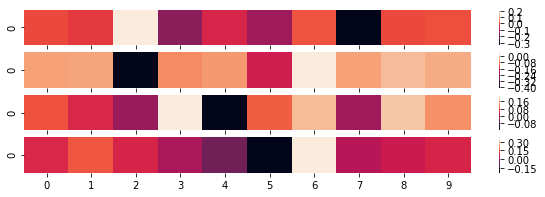

In [0]:
U_neuron(1)

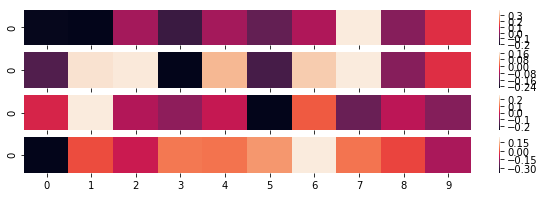

In [0]:
U_neuron(2)

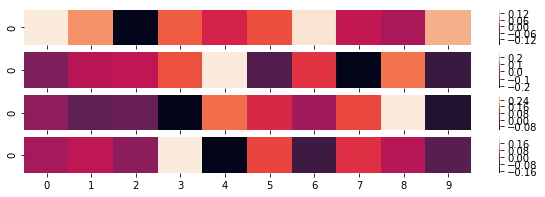

In [0]:
U_neuron(3)

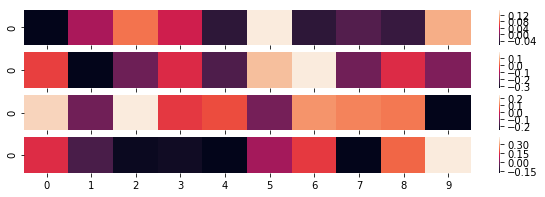

In [0]:
U_neuron(4)

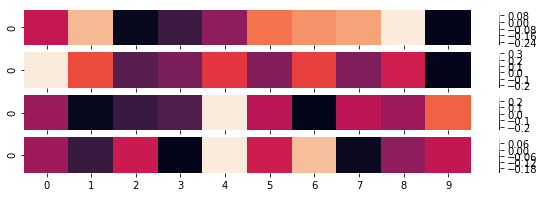

In [0]:
U_neuron(5)

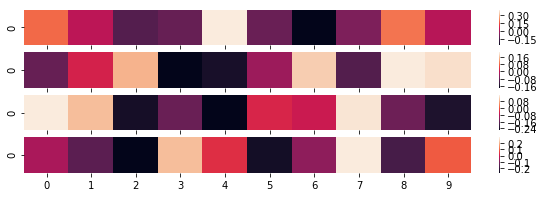

In [0]:
U_neuron(6)

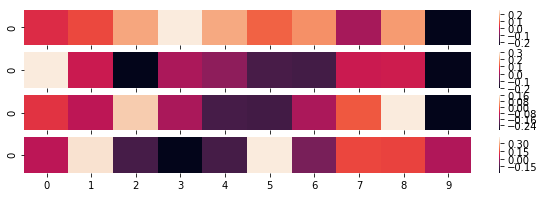

In [0]:
U_neuron(7)

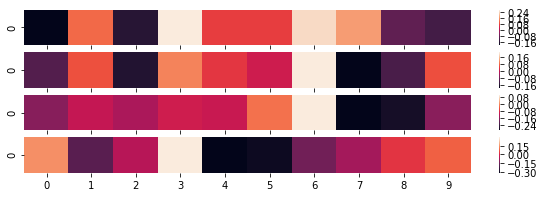

In [0]:
U_neuron(8)

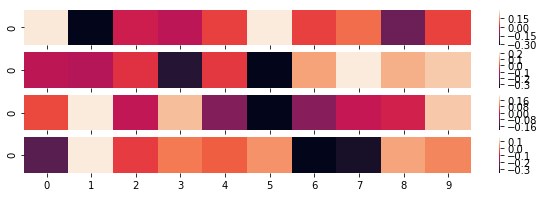

In [0]:
U_neuron(9)

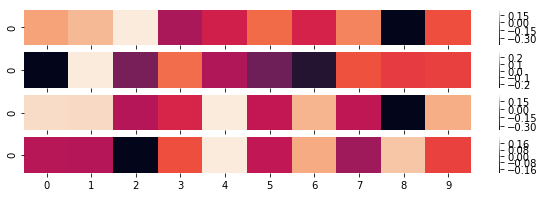

In [0]:
U_neuron(10)

<h1>Model Summaries</h1>

In [0]:
scores = [lstm_test_time_score,
         lstm_2_score]

names = [lstm_time[0]['class_name'],
        lstm_2[0]['class_name']]

batch_input = [lstm_time[0]['config']['batch_input_shape'],
              lstm_2[0]['config']['batch_input_shape']]

layer1_activation = [lstm_time[0]['config']['activation'],
               lstm_2[0]['config']['activation']]

layer1_units = [lstm_time[0]['config']['units'],
               lstm_2[0]['config']['units']]

layer1_dropout = [lstm_time[0]['config']['dropout'],
               lstm_2[0]['config']['dropout']]

layer1_rec_dropout = [lstm_time[0]['config']['recurrent_dropout'],
               lstm_2[0]['config']['recurrent_dropout']]

num_layers = [num_lstm_time_layers,
             num_lstm2_layers]

scores_list = pd.DataFrame(
    {'names': names,
     'MAE': scores,
     'batch_input_size': batch_input,
     'layer1_units': layer1_units,
     'layer1_activation': layer1_activation,
     'layer1_dropout':layer1_dropout,
     'layer1_rec_dropout':layer1_rec_dropout,
     'layers':num_layers
    })

In [0]:
scores_list.sort_values(by='MAE', ascending=True)

,MAE,batch_input_size,layer1_activation,layer1_dropout,layer1_rec_dropout,layer1_units,layers,names
1,0.070716,"(None, 1, 18)",tanh,0.0,0.0,10,2,LSTM
0,2.198919,"(None, 181, 5)",tanh,0.0,0.0,128,3,LSTM
